In [6]:
%load_ext autoreload
%autoreload 2

import os
import sys
import re
import json
from collections import Counter, defaultdict
from itertools import combinations

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

lib_dir = os.path.dirname(os.getcwd())
sys.path.append(lib_dir)

DATASET = "FSD50K.eval_audio"
data_dir = os.path.join(lib_dir, "data")
eval_dir = os.path.join(data_dir, "evaluation_results", DATASET)
figures_dir = os.path.join(data_dir, "figures")

from directories import  AUDIO_DIR

GT_PATH = "../data/eval.csv"

from metrics import find_indices_containing_label

import IPython.display as ipd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## FSD50K Eval Audio Ground Truth Labels

In [2]:
df = pd.read_csv(GT_PATH)
print(df.shape)

fsd_label_counter = Counter([label for labels in df["labels"].apply(lambda x: x.split(",")).to_list() for label in labels])
fsd_label_counter = {k: v for k,v in sorted(fsd_label_counter.items(), key=lambda x: x[1], reverse=True)}
fsd_labels = list(fsd_label_counter.keys())

(10231, 3)


In [3]:
df.head()

,fname,labels,mids
0,37199,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
1,175151,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
2,253463,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
3,329838,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
4,1277,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"


### Plot Label Distribution

#### Sideways

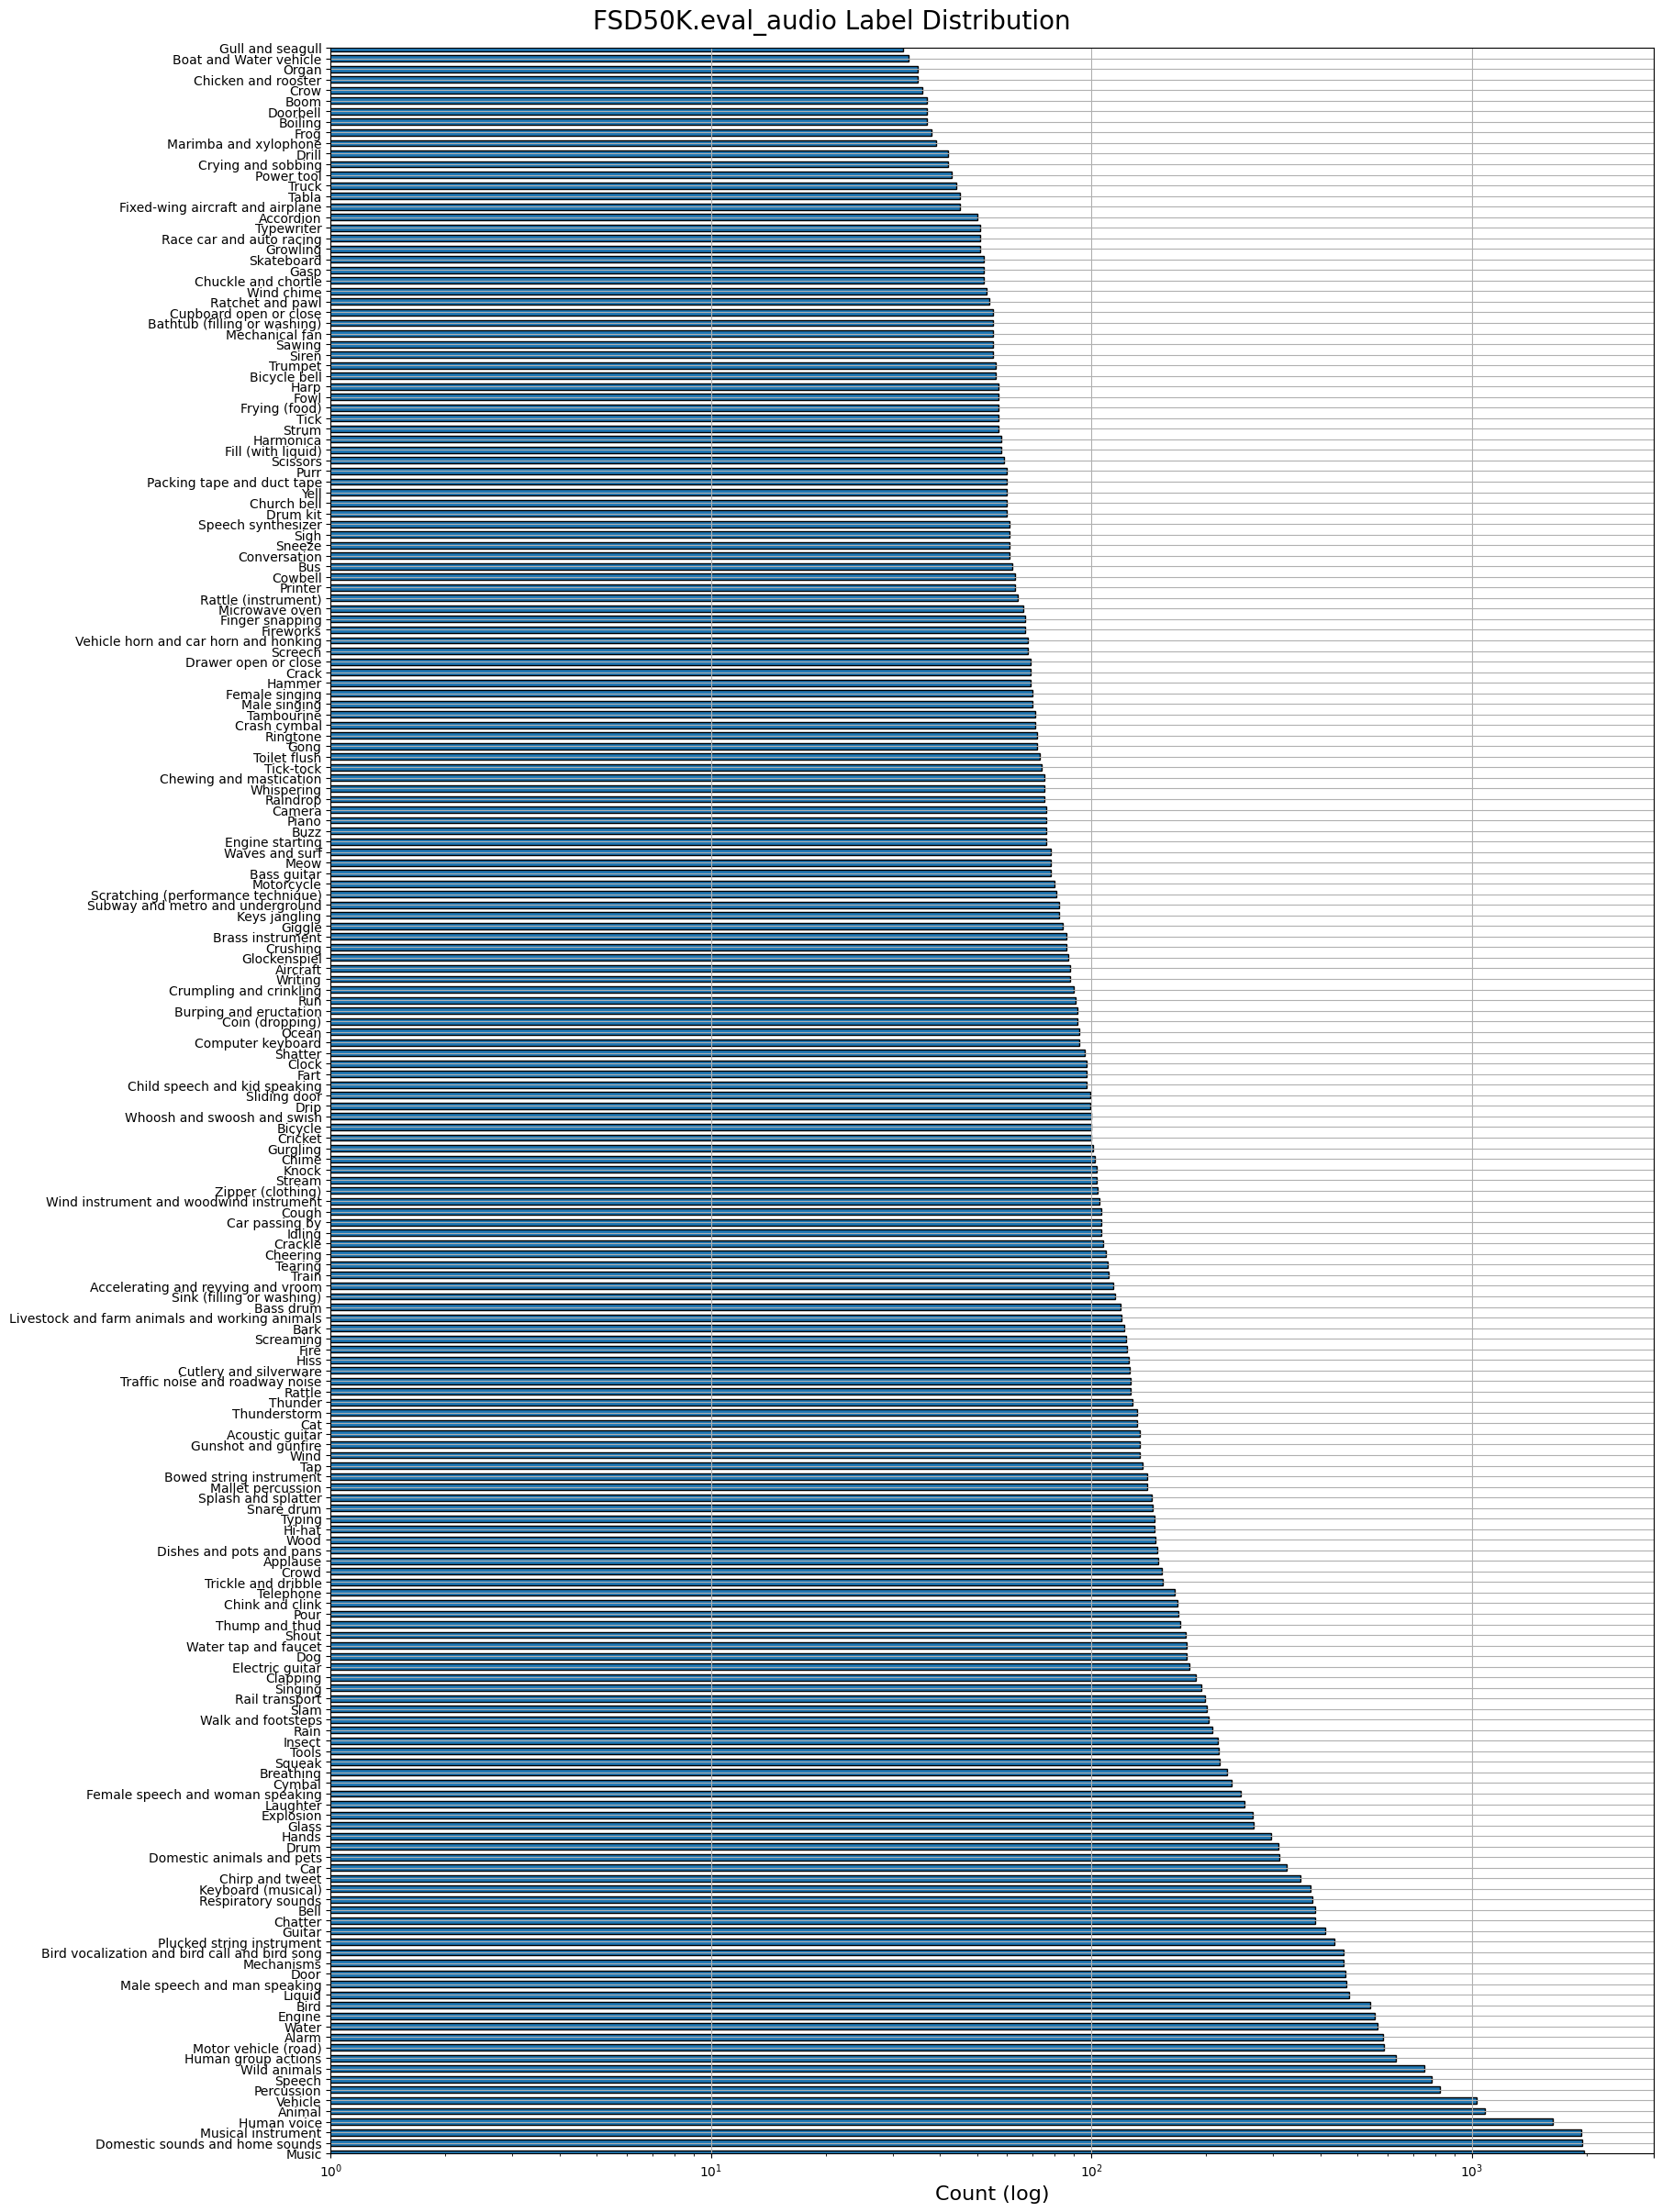

In [20]:
fig, ax = plt.subplots(figsize=(18, 24), constrained_layout=True)
fig.suptitle("FSD50K.eval_audio Label Distribution", fontsize=20)
names = [label.replace("_", " ") for label in fsd_label_counter.keys()]
counts = [count for _, count in fsd_label_counter.items()]
ax.barh(names, counts, height=0.6, edgecolor="black")
ax.set_ylim([names[0], names[-1]])
ax.set_xscale("log")
ax.set_xlabel("Count (log)", fontsize=16)
ax.set_xticks([1, 10, 100, 1000, 3000])
ax.grid()
#fig.savefig(os.path.join(figures_dir, "FSD50K.eval_audio_label_distribution.png"), dpi=300)
plt.show()

#### Cool

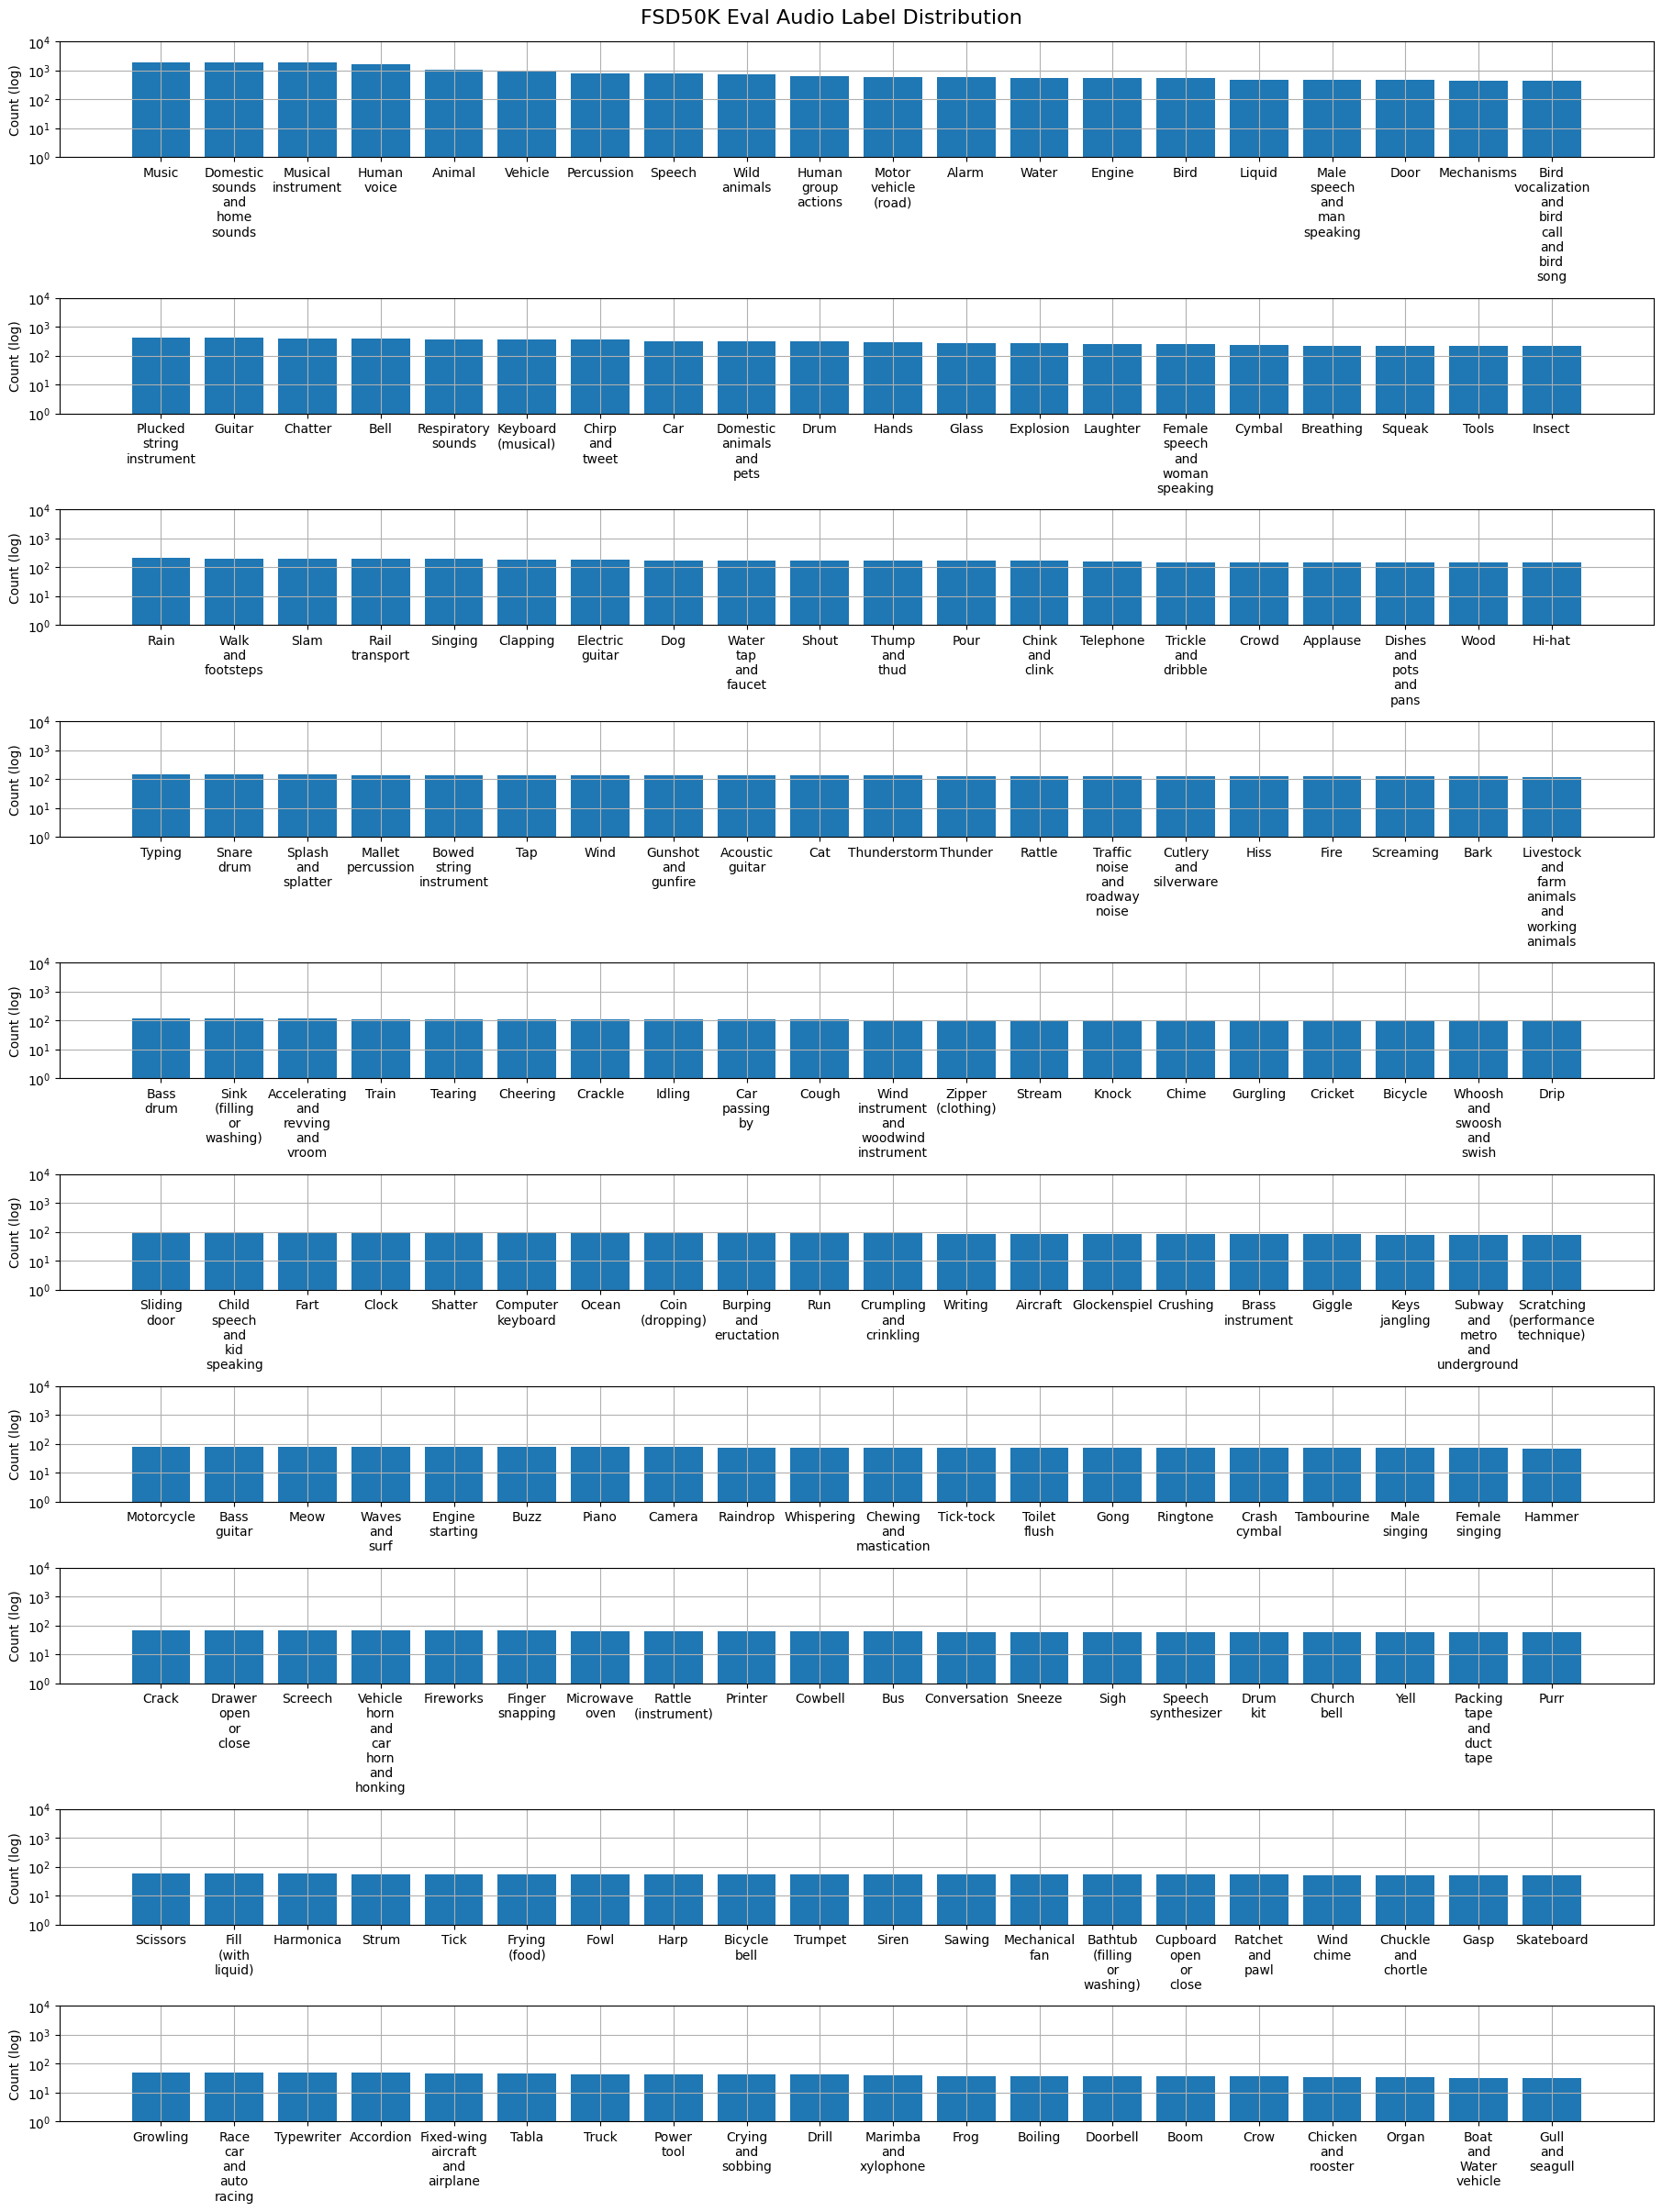

In [40]:
N = 10
delta = len(fsd_label_counter) // N
fig, ax = plt.subplots(figsize=(18, 24), nrows=N, constrained_layout=True)
fig.suptitle("FSD50K Eval Audio Label Distribution", fontsize=16)
for i in range(N):
    ax[i].bar([label.replace("_","\n") for label in list(fsd_label_counter.keys())[i*delta:(i+1)*delta]], 
              [count for count in list(fsd_label_counter.values())[i*delta:(i+1)*delta]])
    ax[i].set_ylim([1, 10**4])
    ax[i].set_ylabel("Count (log)")
    ax[i].set_yscale("log")
    ax[i].set_yticks(ticks = [1, 10, 100,1000,10000])
    ax[i].grid()
plt.show()

## Investigate FSD50K Taxonomy (After Creating It)

In [4]:
from anytree import Node, RenderTree, PreOrderIter
from anytree.importer import DictImporter, JsonImporter
from anytree.exporter import DictExporter, JsonExporter
from PrettyPrint import PrettyPrintTree

def get_full_name(node):
    full_name = []
    while node.name != "root":
        full_name.append(node.name)
        node = node.parent
    return full_name[::-1]

### Load the FSD Taxonomy Tree

In [5]:
with open("../data/taxonomy/FSD50K_reduced_onthology-counts.json", "r") as f:
# with open("../data/taxonomy/fsd_taxonomy_tree.json", "r") as f:
    onthology_dict = json.load(f)
onthology_tree = DictImporter().import_(onthology_dict)
print(RenderTree(onthology_tree))

AnyNode(name='root')
├── AnyNode(name='Music_[1972]')
│   └── AnyNode(name='Musical_instrument_[1940]')
│       ├── AnyNode(name='Harp_[57]')
│       ├── AnyNode(name='Bowed_string_instrument_[140]')
│       ├── AnyNode(name='Brass_instrument_[86]')
│       │   └── AnyNode(name='Trumpet_[56]')
│       ├── AnyNode(name='Harmonica_[58]')
│       ├── AnyNode(name='Percussion_[825]')
│       │   ├── AnyNode(name='Drum_[310]')
│       │   │   ├── AnyNode(name='Tabla_[45]')
│       │   │   ├── AnyNode(name='Snare_drum_[145]')
│       │   │   └── AnyNode(name='Bass_drum_[119]')
│       │   ├── AnyNode(name='Cymbal_[234]')
│       │   │   ├── AnyNode(name='Crash_cymbal_[71]')
│       │   │   └── AnyNode(name='Hi-hat_[146]')
│       │   ├── AnyNode(name='Mallet_percussion_[140]')
│       │   │   ├── AnyNode(name='Glockenspiel_[87]')
│       │   │   └── AnyNode(name='Marimba_and_xylophone_[39]')
│       │   ├── AnyNode(name='Rattle_(instrument)_[64]')
│       │   ├── AnyNode(name='Gong_[72]')
│ 

### Follow Relationships

In [34]:
with open("../data/taxonomy/FSD50K_reduced_onthology.json", "r") as f:
    onthology_dict = json.load(f)
onthology_tree = DictImporter().import_(onthology_dict)
print(RenderTree(onthology_tree))

AnyNode(name='root')
├── AnyNode(name='Music')
│   └── AnyNode(name='Musical_instrument')
│       ├── AnyNode(name='Harp')
│       ├── AnyNode(name='Bowed_string_instrument')
│       ├── AnyNode(name='Brass_instrument')
│       │   └── AnyNode(name='Trumpet')
│       ├── AnyNode(name='Harmonica')
│       ├── AnyNode(name='Percussion')
│       │   ├── AnyNode(name='Drum')
│       │   │   ├── AnyNode(name='Tabla')
│       │   │   ├── AnyNode(name='Snare_drum')
│       │   │   └── AnyNode(name='Bass_drum')
│       │   ├── AnyNode(name='Cymbal')
│       │   │   ├── AnyNode(name='Crash_cymbal')
│       │   │   └── AnyNode(name='Hi-hat')
│       │   ├── AnyNode(name='Mallet_percussion')
│       │   │   ├── AnyNode(name='Glockenspiel')
│       │   │   └── AnyNode(name='Marimba_and_xylophone')
│       │   ├── AnyNode(name='Rattle_(instrument)')
│       │   ├── AnyNode(name='Gong')
│       │   ├── AnyNode(name='Drum_kit')
│       │   └── AnyNode(name='Tambourine')
│       ├── AnyNode(name='Pluc

In [35]:
mapping_dict = {}
for leaf in list(PreOrderIter(onthology_tree, filter_=lambda node: node.name != "root")):
    mapping_dict[leaf.name] = {"path": get_full_name(leaf),
                               "siblings": [sibling.name for sibling in leaf.siblings],
                               "children": [child.name for child in leaf.children],
                               "parent": leaf.parent.name if leaf.parent else None,
                               "depth": leaf.depth,
                               }

In [36]:
mapping_dict["Conversation"]

{'path': ['Human_sounds_(DNE)', 'Human_voice', 'Speech', 'Conversation'],
 'siblings': ['Child_speech_and_kid_speaking',
  'Female_speech_and_woman_speaking',
  'Male_speech_and_man_speaking',
  'Speech_synthesizer'],
 'children': [],
 'parent': 'Speech',
 'depth': 4}

In [40]:
removed_labels = [
            "Bell",
            "Church_bell",
            "Chime",
            "Wind_chime",
            "Chirp_and_tweet",
            "Hiss",
            "Doorbell",
            "Crack",
            "Crackle"
            ]

_df = df.copy()
remove_indices = find_indices_containing_label(removed_labels[0], _df)
for label in removed_labels[1:]:
    remove_indices = remove_indices | find_indices_containing_label(label, _df)
_df = _df[~remove_indices]
_df.shape

(9180, 3)

In [41]:
_df["branches"] = _df["labels"].apply(lambda x: len(set([mapping_dict[label]["path"][0] for label in x.split(",")])))
_df["branches"].apply(lambda x: x).value_counts()

1    7392
2    1590
3     188
4      10
Name: branches, dtype: int64

In [42]:
_df = _df[_df["branches"] == 1]
low_count_labels = []
for label in fsd_labels:
    if label in removed_labels:
        continue
    n = len(_df[find_indices_containing_label(label, _df)])
    if n < 15:
        low_count_labels.append(label)
        print(label, n)
print(len(low_count_labels))
print(low_count_labels)

Knock 0
Buzz 0
Cowbell 0
Tick 8
Bicycle_bell 0
Crow 8
Boat_and_Water_vehicle 12
Gull_and_seagull 6
8
['Knock', 'Buzz', 'Cowbell', 'Tick', 'Bicycle_bell', 'Crow', 'Boat_and_Water_vehicle', 'Gull_and_seagull']


In [43]:
remove_indices = find_indices_containing_label(low_count_labels[0], _df)
for label in low_count_labels[1:]:
    remove_indices = remove_indices | find_indices_containing_label(label, _df)
_df = _df[~remove_indices]
_df.shape
_df.drop(columns=["branches"], inplace=True)
_df.head()

(7358, 4)

In [47]:
_df.to_csv("../data/eval_reduced.csv", index=False)

In [49]:
_df["fname"].to_list()

[37199,
 175151,
 253463,
 329838,
 1277,
 30149,
 331398,
 333246,
 232924,
 42378,
 168741,
 235579,
 1399,
 321709,
 271639,
 60696,
 63890,
 1283,
 317001,
 252854,
 60697,
 1406,
 15753,
 255812,
 334086,
 63883,
 321267,
 47864,
 1408,
 334089,
 44532,
 330901,
 1405,
 263455,
 175152,
 60137,
 42373,
 364119,
 47852,
 333632,
 256462,
 277592,
 363056,
 865,
 363059,
 45584,
 114026,
 336258,
 104616,
 317000,
 255721,
 44298,
 328666,
 175196,
 321708,
 47848,
 401144,
 331397,
 173918,
 336255,
 265318,
 16773,
 63884,
 63885,
 63892,
 316995,
 259663,
 330925,
 336246,
 82177,
 256506,
 218200,
 337898,
 151006,
 368313,
 171353,
 333245,
 257413,
 1373,
 328169,
 364793,
 52081,
 330749,
 55083,
 378012,
 47853,
 47847,
 15752,
 338386,
 175157,
 121189,
 363058,
 85166,
 52347,
 276576,
 331352,
 175186,
 37248,
 256126,
 175159,
 175162,
 47866,
 74873,
 34374,
 260919,
 363060,
 74872,
 187299,
 363057,
 265316,
 351176,
 60141,
 368089,
 401692,
 396473,
 175154,
 368144

['Knock', 
'Buzz', 
'Cowbell', 
'Tick', 
'Bicycle_bell', 
'Crow', 
'Boat_and_Water_vehicle', 
'Gull_and_seagull',
]

### Plot Tree

In [6]:
def center_label(label):
    max_len = max([len(l) for l in label.split("_")])
    lines = []
    for line in label.split("_"):
        line = line.center(max_len)
        lines.append(line)
    return "\n".join(line for line in lines)

f1 = lambda node: node.children
f2 = lambda node: center_label(node.name)
pt = PrettyPrintTree(f1, f2, border=True)

#### Tree Branches

In [18]:
def plot_music_subsets(names, music_name, instrument_name, onthology_dict, pt):
    children = []
    for c in onthology_dict["children"][0]["children"][0]["children"]:
        if re.sub(r"_\[\d+\]", "", c["name"]) in names:
            if "children" in c:
                sub_dict = {"name": c["name"], "children": c["children"]}
            else:
                sub_dict = {"name": c["name"]}
            children.append(sub_dict)
    dct  = {"name": "root", "children": [{"name": music_name, "children": [{"name": instrument_name, "children": children}]}]}

    tree = DictImporter().import_(dct)
    pt(tree.children[0])

def plot_human_subset(names, onthology_dict, human_name, pt):

    children = []
    for c in onthology_dict["children"][1]["children"]:
        if re.sub(r"_\[\d+\]", "", c["name"]) in names:
            if "children" in c:
                sub_dict = {"name": c["name"], "children": c["children"]}
            else:
                sub_dict = {"name": c["name"]}
            children.append(sub_dict)
    #dct  = {"name": "root", "children": [{"name": "Human_sounds_(DNE)", "children": children}]}
    dct  = {"name": "root", "children": [{"name": human_name, "children": children}]}

    tree = DictImporter().import_(dct)
    pt(tree.children[0])

def plot_things_subset(names, onthology_dict, things_name, pt):
    children = []
    for c in onthology_dict["children"][4]["children"]:
        if re.sub(r"_\[\d+\]", "", c["name"]) in names:
            if "children" in c:
                sub_dict = {"name": c["name"], "children": c["children"]}
            else:
                sub_dict = {"name": c["name"]}
            children.append(sub_dict)
    music1_dict  = {"name": "root", "children": [{"name": things_name, "children": children}]}

    music1 = DictImporter().import_(music1_dict)
    pt(music1.children[0])

In [19]:
main_nodes = [node.name for node in (onthology_tree).children]
for node in main_nodes:
    print(node)

Music_[1972]
Human_sounds_[0]
Animal_[1082]
Source-ambiguous_sounds_[0]
Sounds_of_things_[0]
Natural_sounds_[0]


##### Music

In [9]:
music_nodes = [node.name for node in onthology_tree.children[0].children[0].children]
for node in sorted(music_nodes):
    print(node)
print(len(music_nodes))

Accordion_[50]
Bowed_string_instrument_[140]
Brass_instrument_[86]
Harmonica_[58]
Harp_[57]
Keyboard_(musical)_[376]
Percussion_[825]
Plucked_string_instrument_[434]
Scratching_(performance_technique)_[81]
Wind_instrument_and_woodwind_instrument_[105]
10


In [10]:
names = [
        "Percussion",
        "Scratching_(performance_technique)", 
        ]
plot_music_subsets(names, 
                   main_nodes[0], 
                   onthology_tree.children[0].children[0].name, 
                   onthology_dict,
                   pt)

                                                                                       ┌──────┐
                                                                                       │Music │
                                                                                       │[1972]│
                                                                                       └──────┘
                                                                                          │
                                                                                    ┌──────────┐
                                                                                    │ Musical  │
                                                                                    │instrument│
                                                                                    │  [1940]  │
                                                                                    └──────────┘
                                       

In [11]:
names = [
        "Brass_instrument", 
        "Harmonica", 
        "Wind_instrument_and_woodwind_instrument", 
        ]
plot_music_subsets(names, 
                   main_nodes[0], 
                   onthology_tree.children[0].children[0].name, 
                   onthology_dict,
                   pt)

                 ┌──────┐
                 │Music │
                 │[1972]│
                 └──────┘
                    │
              ┌──────────┐
              │ Musical  │
              │instrument│
              │  [1940]  │
              └──────────┘
      ┌───────────┬┴───────────┐
┌──────────┐ ┌─────────┐ ┌──────────┐
│  Brass   │ │Harmonica│ │   Wind   │
│instrument│ │   [58]  │ │instrument│
│   [86]   │ └─────────┘ │   and    │
└──────────┘             │ woodwind │
    │                    │instrument│
┌───────┐                │  [105]   │
│Trumpet│                └──────────┘
│  [56] │
└───────┘


In [12]:
names = [
        "Keyboard_(musical)",
        "Accordion", 
        ]
plot_music_subsets(names, 
                   main_nodes[0], 
                   onthology_tree.children[0].children[0].name, 
                   onthology_dict,
                   pt)

          ┌──────┐
          │Music │
          │[1972]│
          └──────┘
             │
       ┌──────────┐
       │ Musical  │
       │instrument│
       │  [1940]  │
       └──────────┘
     ┌──────┴──────┐
┌─────────┐   ┌─────────┐
│Accordion│   │ Keyboard│
│   [50]  │   │(musical)│
└─────────┘   │  [376]  │
              └─────────┘
               ┌───┴───┐
            ┌─────┐ ┌─────┐
            │Organ│ │Piano│
            │ [35]│ │ [76]│
            └─────┘ └─────┘


In [13]:
names = [
        "Harp", 
        "Bowed_string_instrument", 
        "Plucked_string_instrument", 
        ]
plot_music_subsets(names, 
                   main_nodes[0], 
                   onthology_tree.children[0].children[0].name, 
                   onthology_dict,
                   pt)

                    ┌──────┐
                    │Music │
                    │[1972]│
                    └──────┘
                       │
                 ┌──────────┐
                 │ Musical  │
                 │instrument│
                 │  [1940]  │
                 └──────────┘
   ┌─────────┬────────┴──────────────────┐
┌────┐ ┌──────────┐                ┌──────────┐
│Harp│ │  Bowed   │                │ Plucked  │
│[57]│ │  string  │                │  string  │
└────┘ │instrument│                │instrument│
       │  [140]   │                │  [434]   │
       └──────────┘                └──────────┘
                                        │
                                    ┌──────┐
                                    │Guitar│
                                    │[411] │
                                    └──────┘
                       ┌─────────┬─────┴────┬─────────┐
                    ┌─────┐ ┌────────┐ ┌────────┐ ┌──────┐
                    │Strum│ │Acoustic│ │E

##### Human Sounds

In [14]:
print(onthology_tree.children[1].name)
human_nodes = [node.name for node in onthology_tree.children[1].children]
for node in sorted(human_nodes):
    print(node)
print(len(human_nodes))

Burping_and_eructation_[92]
Chewing_and_mastication_[75]
Fart_[97]
Hands_[297]
Human_group_actions_[631]
Human_voice_[1633]
Respiratory_sounds_[380]
Run_[91]
Walk_and_footsteps_[203]
9


In [21]:
names = ["Human_voice"]
plot_human_subset(names, onthology_dict, onthology_tree.children[1].name, pt)

                                                                       ┌──────┐
                                                                       │Human │
                                                                       │sounds│
                                                                       │ [0]  │
                                                                       └──────┘
                                                                          │
                                                                      ┌──────┐
                                                                      │Human │
                                                                      │voice │
                                                                      │[1633]│
                                                                      └──────┘
    ┌────────┬─────────┬───────────────┬─────────────────────────────────┴────────┬────────────────────────────────┬─────────┬───

In [22]:
names = [
        "Human_group_actions", 
        "Hands", 
        "Respiratory_sounds", 
        "Fart", 
        "Burping_and_eructation", 
        "Chewing_and_mastication", 
        "Run", 
        "Walk_and_footsteps"
        ]
plot_human_subset(names, onthology_dict, onthology_tree.children[1].name, pt)

                                                                            ┌──────┐
                                                                            │Human │
                                                                            │sounds│
                                                                            │ [0]  │
                                                                            └──────┘
                    ┌──────────────────────────────┬───────────────────────┬───┴──────────────┬─────────┬────────────┬──────────┬────────┐
                ┌───────┐                       ┌─────┐              ┌───────────┐         ┌────┐ ┌──────────┐ ┌───────────┐ ┌────┐ ┌─────────┐
                │ Human │                       │Hands│              │Respiratory│         │Fart│ │ Burping  │ │  Chewing  │ │Run │ │   Walk  │
                │ group │                       │[297]│              │   sounds  │         │[97]│ │   and    │ │    and    │ │[91]│ │   and   │
    

##### Sounds of Things

In [23]:
print(onthology_tree.children[4].name)
things_nodes = [node.name for node in onthology_tree.children[4].children]
for node in sorted(things_nodes):
    print(node)
print(len(things_nodes))

Sounds_of_things_[0]
Alarm_[584]
Domestic_sounds_and_home_sounds_[1947]
Engine_[554]
Explosion_[266]
Glass_[267]
Liquid_[476]
Mechanisms_[461]
Thump_and_thud_[171]
Tools_[216]
Vehicle_[1030]
Wood_[147]
11


In [24]:
names = [
        "Vehicle",
        "Engine",
        ]
plot_things_subset(names, onthology_dict, onthology_tree.children[4].name, pt)

                                                                                                            ┌──────┐
                                                                                                            │Sounds│
                                                                                                            │  of  │
                                                                                                            │things│
                                                                                                            │ [0]  │
                                                                                                            └──────┘
                                                                   ┌───────────────────────────────────────────┴───────────────────────────────────────────┐
                                                               ┌───────┐                                                                     

In [25]:
names = [
        "Thump_and_thud",
        "Glass",
        "Wood",
        "Explosion",
        ]
plot_things_subset(names, onthology_dict, onthology_tree.children[4].name, pt)

                       ┌──────┐
                       │Sounds│
                       │  of  │
                       │things│
                       │ [0]  │
                       └──────┘
   ┌────────────┬─────────┴──┬───────────────────┐
┌─────┐      ┌─────┐      ┌─────┐           ┌─────────┐
│Thump│      │Glass│      │ Wood│           │Explosion│
│ and │      │[267]│      │[147]│           │  [266]  │
│ thud│      └─────┘      └─────┘           └─────────┘
│[171]│    ┌────┴───┐                  ┌─────────┴┬────────┐
└─────┘ ┌─────┐ ┌───────┐         ┌─────────┐ ┌───────┐ ┌────┐
        │Chink│ │Shatter│         │Fireworks│ │Gunshot│ │Boom│
        │ and │ │  [96] │         │   [67]  │ │  and  │ │[37]│
        │clink│ └───────┘         └─────────┘ │gunfire│ └────┘
        │[168]│                               │ [134] │
        └─────┘                               └───────┘


In [26]:
names = [
        "Liquid",
        "Alarm",
        "Tools",
        "Mechanisms",
        ]
plot_things_subset(names, onthology_dict, onthology_tree.children[4].name, pt)

                                                                           ┌──────┐
                                                                           │Sounds│
                                                                           │  of  │
                                                                           │things│
                                                                           │ [0]  │
                                                                           └──────┘
                        ┌─────────────────────────────────────┬───────────────┴────────────┬────────────────────────────────────────┐
                    ┌──────┐                               ┌─────┐                      ┌─────┐                               ┌──────────┐
                    │Liquid│                               │Alarm│                      │Tools│                               │Mechanisms│
                    │[476] │                               │[584]│                  

In [27]:
names = [
        "Domestic_sounds_and_home_sounds",
        ]
plot_things_subset(names, onthology_dict, onthology_tree.children[4].name, pt)

                                                                                                        ┌──────┐
                                                                                                        │Sounds│
                                                                                                        │  of  │
                                                                                                        │things│
                                                                                                        │ [0]  │
                                                                                                        └──────┘
                                                                                                           │
                                                                                                      ┌────────┐
                                                                                                    

##### Animal

In [28]:
print(onthology_tree.children[2].name)
animal_nodes = [node.name for node in onthology_tree.children[2].children]
for node in sorted(animal_nodes):
    print(node)
print(len(animal_nodes))

Animal_[1082]
Domestic_animals_and_pets_[311]
Livestock_and_farm_animals_and_working_animals_[120]
Wild_animals_[751]
3


In [29]:
pt(onthology_tree.children[2], orientation=PrettyPrintTree.VERTICAL)

                                                   ┌──────┐
                                                   │Animal│
                                                   │[1082]│
                                                   └──────┘
                ┌─────────────────────────────────────┴──┬──────────────────────────────────┐
           ┌────────┐                                ┌───────┐                         ┌─────────┐
           │Domestic│                                │  Wild │                         │Livestock│
           │animals │                                │animals│                         │   and   │
           │  and   │                                │ [751] │                         │   farm  │
           │  pets  │                                └───────┘                         │ animals │
           │ [311]  │               ┌──────────────────┬─┴───────────────────┐         │   and   │
           └────────┘            ┌────┐             ┌─────┐             

##### Source-ambiguous_sounds

In [31]:
ambiguous_nodes = [node.name for node in onthology_tree.children[3].children]
for node in sorted(ambiguous_nodes):
    print(node)
print(len(ambiguous_nodes))

Buzz_[76]
Crumpling_and_crinkling_[90]
Crushing_[86]
Knock_[103]
Rattle_[127]
Screech_[68]
Squeak_[217]
Tap_[136]
Tearing_[110]
Tick_[57]
Whoosh_and_swoosh_and_swish_[100]
11


In [32]:
pt(onthology_tree.children[3], orientation=PrettyPrintTree.VERTICAL)

                                          ┌────────────────┐
                                          │Source-ambiguous│
                                          │     sounds     │
                                          │      [0]       │
                                          └────────────────┘
     ┌───────────┬────────┬───────┬────────┬──────┴─┬────────┬─────────┬───────┬──────┬───────┐
┌─────────┐ ┌────────┐ ┌─────┐ ┌─────┐ ┌──────┐ ┌──────┐ ┌───────┐ ┌──────┐ ┌────┐ ┌────┐ ┌───────┐
│Crumpling│ │Crushing│ │Knock│ │ Tap │ │Rattle│ │Whoosh│ │Screech│ │Squeak│ │Buzz│ │Tick│ │Tearing│
│   and   │ │  [86]  │ │[103]│ │[136]│ │[127] │ │ and  │ │  [68] │ │[217] │ │[76]│ │[57]│ │ [110] │
│crinkling│ └────────┘ └─────┘ └─────┘ └──────┘ │swoosh│ └───────┘ └──────┘ └────┘ └────┘ └───────┘
│   [90]  │                                     │ and  │
└─────────┘                                     │swish │
                                                │[100] │
                            

##### Natural

In [33]:
natural_nodes = [node.name for node in onthology_tree.children[5].children]
for node in sorted(natural_nodes):
    print(node)
print(len(natural_nodes))

Fire_[124]
Thunderstorm_[132]
Wind_[134]
3


In [34]:
pt(onthology_tree.children[5], orientation=PrettyPrintTree.VERTICAL)

                                        ┌───────┐
                                        │Natural│
                                        │ sounds│
                                        │  [0]  │
                                        └───────┘
                         ┌──────────────────┴────────┬────────┐
                  ┌────────────┐                  ┌─────┐  ┌─────┐
                  │Thunderstorm│                  │ Fire│  │ Wind│
                  │   [132]    │                  │[124]│  │[134]│
                  └────────────┘                  └─────┘  └─────┘
    ┌──────────┬────────┴┬───────┬─────────┐         │
┌───────┐   ┌─────┐  ┌──────┐ ┌─────┐   ┌─────┐  ┌───────┐
│Thunder│   │ Rain│  │Stream│ │Ocean│   │Water│  │Crackle│
│ [128] │   │[208]│  │[103] │ │ [93]│   │[565]│  │ [107] │
└───────┘   └─────┘  └──────┘ └─────┘   └─────┘  └───────┘
               │                 │         │
          ┌────────┐          ┌─────┐ ┌────────┐
          │Raindrop│          │Wa

#### Full Plots

In [ ]:
# Keep this and do not create a method for it
f1 = lambda node: node.children
f2 = lambda node: node.name.replace("_", "\n")
pt = PrettyPrintTree(f1, f2, border=True)

In [ ]:
pt(onthology_tree.children[1], orientation=PrettyPrintTree.VERTICAL)

In [ ]:
pt(onthology_tree.children[2], orientation=PrettyPrintTree.VERTICAL)

In [ ]:
pt(onthology_tree.children[3], orientation=PrettyPrintTree.VERTICAL)

In [ ]:
pt(onthology_tree.children[4], orientation=PrettyPrintTree.VERTICAL)

In [ ]:
pt(onthology_tree.children[5], orientation=PrettyPrintTree.VERTICAL)

### Listen To Removed Labels

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from essentia.standard import EasyLoader

In [ ]:
removed_labels = [
            "Bell",
            "Church_bell",
            "Chime",
            "Wind_chime",
            "Chirp_and_tweet",
            "Hiss",
            "Doorbell",
            "Crack"
            ]
fnames_of_interest = dict()
for label in removed_labels:
    fnames_of_interest[label] = df[df["labels"].str.contains(label)]["fname"].to_list()
    print(f"{label}: {len(fnames_of_interest[label])}")

In [ ]:
fname = fnames_of_interest["Doorbell"][0]
print(fname)
print(df[df["fname"]==fname]["labels"].to_list()[0].replace(",", "\n"))
audio_path = os.path.join(AUDIO_DIR, 
                          str(fname)+".wav")
ipd.Audio(audio_path)

## Create Audioset Onthology and FSD50K Taxonomy Tree

#### Scrape Audioset

In [8]:
import requests
from bs4 import BeautifulSoup

In [9]:
URL = "https://research.google.com/audioset/ontology/"

def format_name(name):
    if name=="Dishes, pots, and pans":
        return "Dishes_and_pots_and_pans"
    elif name.lower()=='boat, water vehicle':
        return "Boat_and_Water_vehicle"
    else:
        name = name[0].capitalize()+name[1:].lower()
        name = name.replace(" ", "_")
        name = name.replace(",", "_and")
        return name

def get_branch(branch_url):
    branch_response = requests.get(branch_url)
    if branch_response.status_code != 200:
        raise Exception(f"Failed to load {branch_url}.")
    else:
        info = []
        branch_soup = BeautifulSoup(branch_response.text, "html.parser")
        for leaf in branch_soup.find_all("li", {"class": "B"}):
            leaf = leaf.find("a")
            leaf_url = URL+leaf.get('href')
            leaf_name = leaf.text
            info.append((leaf_name, leaf_url))
    return info

def parse_audioset(name_format=False, load=False, save=False):

    if load:
        importer = JsonImporter()
        with open("../data/taxonomy/Audioset_ontology.json", "r") as infile:
            tree_dict = json.load(infile)
        root = importer.import_(json.dumps(tree_dict))
        return root
    else:
        response = requests.get(URL+"index.html")
        if response.status_code != 200:
            raise Exception("Failed to load the ontology page.")
        else:
            print("Successfully loaded the ontology page.")
            soup = BeautifulSoup(response.text, "html.parser")

            root = Node("root")
            for column in soup.find("div", {"id": "branches"}).find_all("div", {"class": "Pb"}):

                branches = column.find_all("h2", {"class": "n"})
                l1_info = [(branch.text, URL+branch.a.get('href')) for branch in branches]

                # Level 1
                for branch_name, branch_url in l1_info:
                    if name_format:
                        branch_name = format_name(branch_name)
                    l1_node = Node(branch_name, parent=root)
                    l2_info = get_branch(branch_url)

                    # Level 2
                    for l2_name, l2_url in l2_info:
                        if name_format:
                            l2_name = format_name(l2_name)
                        l2_node = Node(l2_name, parent=l1_node)
                        l3_info = get_branch(l2_url)

                        # Level 3
                        for l3_name, l3_url in l3_info:
                            if name_format:
                                l3_name = format_name(l3_name)
                            l3_node = Node(l3_name, parent=l2_node)
                            l4_info = get_branch(l3_url)

                            # Level 4
                            for l4_name, l4_url in l4_info:
                                if name_format:
                                    l4_name = format_name(l4_name)
                                l4_node = Node(l4_name, parent=l3_node)
                                l5_info = get_branch(l4_url)

                                # Level 5
                                for l5_name, l5_url in l5_info:
                                    if name_format:
                                        l5_name = format_name(l5_name)
                                    l5_node = Node(l5_name, parent=l4_node)
                                    l6_info = get_branch(l5_url)

                                    # Level 6
                                    for l6_name, l6_url in l6_info:
                                        if name_format:
                                            l6_name = format_name(l6_name)
                                        l6_node = Node(l6_name, parent=l5_node)

            if save:
                exporter = DictExporter()
                tree_dict = exporter.export(root)
                with open("../data/taxonomy/Audioset_ontology.json", "w") as outfile:
                    json.dump(tree_dict, outfile, indent=4)

            return root

In [10]:
audioset_onthology = parse_audioset(load=True, name_format=True, save=False)
print(RenderTree(audioset_onthology))

AnyNode(name='root')
├── AnyNode(name='Human_sounds')
│   ├── AnyNode(name='Human_voice')
│   │   ├── AnyNode(name='Speech')
│   │   │   ├── AnyNode(name='Male_speech_and_man_speaking')
│   │   │   ├── AnyNode(name='Female_speech_and_woman_speaking')
│   │   │   ├── AnyNode(name='Child_speech_and_kid_speaking')
│   │   │   ├── AnyNode(name='Conversation')
│   │   │   ├── AnyNode(name='Narration_and_monologue')
│   │   │   ├── AnyNode(name='Babbling')
│   │   │   └── AnyNode(name='Speech_synthesizer')
│   │   ├── AnyNode(name='Shout')
│   │   │   ├── AnyNode(name='Bellow')
│   │   │   ├── AnyNode(name='Whoop')
│   │   │   ├── AnyNode(name='Yell')
│   │   │   ├── AnyNode(name='Battle_cry')
│   │   │   └── AnyNode(name='Children_shouting')
│   │   ├── AnyNode(name='Screaming')
│   │   ├── AnyNode(name='Whispering')
│   │   ├── AnyNode(name='Laughter')
│   │   │   ├── AnyNode(name='Baby_laughter')
│   │   │   ├── AnyNode(name='Giggle')
│   │   │   ├── AnyNode(name='Snicker')
│   │   │   ├─

#### Map FSD Labels to Audioset root

In [11]:
audioset_nodes = [leaf for leaf in list(PreOrderIter(audioset_onthology, filter_=lambda node: node.name != "root"))]
print(len(audioset_nodes))
audioset_leaves = [leaf for leaf in list(PreOrderIter(audioset_onthology, filter_=lambda node: node.is_leaf and node.name != "root"))]
print(len(audioset_leaves))

audioset_node_branches = [get_full_name(node) for node in audioset_nodes]

690
526


In [12]:
# Find the FSD labels that are not in the Audioset ontology while mapping the FSD labels to the Audioset labels
mappings = {}
for fsd_label in fsd_labels:
    found = False
    for audioset_node_branch in audioset_node_branches:
        if fsd_label==audioset_node_branch[-1]:
            found = True
            mappings[fsd_label] = audioset_node_branch
            break
    if not found:
        print(fsd_label, "not found")

In [13]:
print(json.dumps(mappings, indent=4))

{
    "Music": [
        "Music"
    ],
    "Domestic_sounds_and_home_sounds": [
        "Sounds_of_things",
        "Domestic_sounds_and_home_sounds"
    ],
    "Musical_instrument": [
        "Music",
        "Musical_instrument"
    ],
    "Human_voice": [
        "Human_sounds",
        "Human_voice"
    ],
    "Animal": [
        "Animal"
    ],
    "Vehicle": [
        "Sounds_of_things",
        "Vehicle"
    ],
    "Percussion": [
        "Music",
        "Musical_instrument",
        "Percussion"
    ],
    "Speech": [
        "Human_sounds",
        "Human_voice",
        "Speech"
    ],
    "Wild_animals": [
        "Animal",
        "Wild_animals"
    ],
    "Human_group_actions": [
        "Human_sounds",
        "Human_group_actions"
    ],
    "Motor_vehicle_(road)": [
        "Sounds_of_things",
        "Vehicle",
        "Motor_vehicle_(road)"
    ],
    "Alarm": [
        "Sounds_of_things",
        "Alarm"
    ],
    "Water": [
        "Natural_sounds",
        "Wate

In [14]:
# Follow the branches of FSD label through the Audioset ontology and keep only intermediate nodes that are in the FSD labels
reduced_mappings = {}
for fsd_label, audioset_branch in mappings.items():
    reduced_mappings[fsd_label] = [node for node in audioset_branch if node in fsd_labels]
print(json.dumps(reduced_mappings, indent=4))

{
    "Music": [
        "Music"
    ],
    "Domestic_sounds_and_home_sounds": [
        "Domestic_sounds_and_home_sounds"
    ],
    "Musical_instrument": [
        "Music",
        "Musical_instrument"
    ],
    "Human_voice": [
        "Human_voice"
    ],
    "Animal": [
        "Animal"
    ],
    "Vehicle": [
        "Vehicle"
    ],
    "Percussion": [
        "Music",
        "Musical_instrument",
        "Percussion"
    ],
    "Speech": [
        "Human_voice",
        "Speech"
    ],
    "Wild_animals": [
        "Animal",
        "Wild_animals"
    ],
    "Human_group_actions": [
        "Human_group_actions"
    ],
    "Motor_vehicle_(road)": [
        "Vehicle",
        "Motor_vehicle_(road)"
    ],
    "Alarm": [
        "Alarm"
    ],
    "Water": [
        "Water"
    ],
    "Engine": [
        "Engine"
    ],
    "Bird": [
        "Animal",
        "Wild_animals",
        "Bird"
    ],
    "Liquid": [
        "Liquid"
    ],
    "Male_speech_and_man_speaking": [
    

This tree will not be good because FSD deletes a lot of main and intermediate nodes.

In [16]:
fsd_root = Node("root")
for fsd_branch in reduced_mappings.values():
    node = Node(fsd_branch[0], parent=fsd_root)
    for i in range(1, len(fsd_branch)):
        c_node = Node(fsd_branch[i], parent=node)
print(RenderTree(fsd_root))
if False:
    exporter = DictExporter()
    tree_dict = exporter.export(fsd_root)
    with open("../data/taxonomy/FSD50K_ontology.json", "w") as outfile:
        json.dump(tree_dict, outfile, indent=4)

Node('/root')
├── Node('/root/Music')
├── Node('/root/Domestic_sounds_and_home_sounds')
├── Node('/root/Music')
│   └── Node('/root/Music/Musical_instrument')
├── Node('/root/Human_voice')
├── Node('/root/Animal')
├── Node('/root/Vehicle')
├── Node('/root/Music')
│   ├── Node('/root/Music/Musical_instrument')
│   └── Node('/root/Music/Percussion')
├── Node('/root/Human_voice')
│   └── Node('/root/Human_voice/Speech')
├── Node('/root/Animal')
│   └── Node('/root/Animal/Wild_animals')
├── Node('/root/Human_group_actions')
├── Node('/root/Vehicle')
│   └── Node('/root/Vehicle/Motor_vehicle_(road)')
├── Node('/root/Alarm')
├── Node('/root/Water')
├── Node('/root/Engine')
├── Node('/root/Animal')
│   ├── Node('/root/Animal/Wild_animals')
│   └── Node('/root/Animal/Bird')
├── Node('/root/Liquid')
├── Node('/root/Human_voice')
│   ├── Node('/root/Human_voice/Speech')
│   └── Node('/root/Human_voice/Male_speech_and_man_speaking')
├── Node('/root/Domestic_sounds_and_home_sounds')
│   └── Node('

##### Solution is to Use your Own hard work

In [17]:
with open("../data/taxonomy/FSD_onthology.text", "r") as in_f:
    onthology_text = in_f.read().splitlines()
print(len(onthology_text))

209


In [18]:
n = 0
FSD_onthology_all_labels = []
for line in onthology_text:
    line = re.sub(r"\s*-\s", "", line)
    FSD_onthology_all_labels.append(line)
    if line not in fsd_labels:
        print(line)
        n += 1
print(n)

Human_sounds (DNE)
Digestive (DNE)
Human_locomotion (DNE)
Cattle_and_bovinae (DNE)
Source-ambiguous_sounds (DNE)
Deformable_shell (DNE)
Generic_impact_sounds (DNE)
Onomatopoeia (DNE)
Brief_tone (DNE)
Clicking (DNE)
Deformable_shell (DNE)
Sounds_of_things (DNE)
Miscellaneous_sources (DNE)
Arrow (DNE)
Non-motorized_land_vehicle (DNE)
Natural_sounds (DNE)
Channel_and_environment_and_background (DNE)
17


These are labels that exist in FSd50k but I removed them since they can belong to different families.

In [19]:
n = 0
for label in fsd_labels:
    if label not in FSD_onthology_all_labels:
        print(label)
        n += 1
print(n)

Bell
Chirp_and_tweet
Hiss
Chime
Crack
Church_bell
Wind_chime
Doorbell
8


In [20]:

onthology_my = {"name": "root", "children": []}
for line in onthology_text:
    idx = line.index("- ")
    label = line[idx+2:]
    if idx==0 and label not in onthology_my:
        onthology_my["children"].append({"name": label, "children": []})
        l1_label = label
    elif idx==4:
        for child in onthology_my["children"]:
            if child["name"]==l1_label:
                child["children"].append({"name": label, "children": []})
                break
        l2_label = label
    elif idx==8:
        for child in onthology_my["children"]:
            if child["name"]==l1_label:
                for child2 in child["children"]:
                    if child2["name"]==l2_label:
                        child2["children"].append({"name": label, "children": []})
                        break
                break
        l3_label = label
    elif idx==12:
        for child in onthology_my["children"]:
            if child["name"]==l1_label:
                for child2 in child["children"]:
                    if child2["name"]==l2_label:
                        for child3 in child2["children"]:
                            if child3["name"]==l3_label:
                                child3["children"].append({"name": label, "children": []})
                                break
                        break
                break
        l4_label = label
    elif idx==16:
        for child in onthology_my["children"]:
            if child["name"]==l1_label:
                for child2 in child["children"]:
                    if child2["name"]==l2_label:
                        for child3 in child2["children"]:
                            if child3["name"]==l3_label:
                                for child4 in child3["children"]:
                                    if child4["name"]==l4_label:
                                        child4["children"].append({"name": label, "children": []})
                                        break
                                break
                        break
                break
        l5_label = label
importer = DictImporter()
my_root = importer.import_(onthology_my)
print(RenderTree(my_root))

AnyNode(name='root')
├── AnyNode(name='Music')
│   └── AnyNode(name='Musical_instrument')
│       ├── AnyNode(name='Harp')
│       ├── AnyNode(name='Bowed_string_instrument')
│       ├── AnyNode(name='Brass_instrument')
│       │   └── AnyNode(name='Trumpet')
│       ├── AnyNode(name='Harmonica')
│       ├── AnyNode(name='Percussion')
│       │   ├── AnyNode(name='Drum')
│       │   │   ├── AnyNode(name='Tabla')
│       │   │   ├── AnyNode(name='Snare_drum')
│       │   │   └── AnyNode(name='Bass_drum')
│       │   ├── AnyNode(name='Cymbal')
│       │   │   ├── AnyNode(name='Crash_cymbal')
│       │   │   └── AnyNode(name='Hi-hat')
│       │   ├── AnyNode(name='Mallet_percussion')
│       │   │   ├── AnyNode(name='Glockenspiel')
│       │   │   └── AnyNode(name='Marimba_and_xylophone')
│       │   ├── AnyNode(name='Rattle_(instrument)')
│       │   ├── AnyNode(name='Gong')
│       │   ├── AnyNode(name='Drum_kit')
│       │   └── AnyNode(name='Tambourine')
│       ├── AnyNode(name='Pluc

In [21]:
with open("../data/taxonomy/FSD_onthology_reduced.text", "r") as in_f:
    onthology_text = in_f.read().splitlines()
print(len(onthology_text))

196


In [22]:
# Check for dublicates
my_lines = []
for line in onthology_text:
    line = re.sub(r"\s*-\s", "", line)
    if line not in my_lines:
        my_lines.append(line)
    else:
        print(line)

# Check for missing labels, collect labels
my_onthology_labels = []
for line in onthology_text:
    line = re.sub(r"\s*-\s", "", line)
    my_onthology_labels.append(line)
    if line not in fsd_labels:
        print(line)

print()
for label in fsd_labels:
    if label not in my_onthology_labels:
        print(label)

Human_sounds_(DNE)
Source-ambiguous_sounds_(DNE)
Sounds_of_things_(DNE)
Natural_sounds_(DNE)

Bell
Chirp_and_tweet
Hiss
Chime
Crack
Church_bell
Wind_chime
Doorbell


In [23]:
save = True

onthology_my_reduced = {"name": "root", "children": []}
for line in onthology_text:
    idx = line.index("- ")
    label = line[idx+2:]
    if idx==0 and label not in onthology_my_reduced:
        onthology_my_reduced["children"].append({"name": label, "children": []})
        l1_label = label
    elif idx==4:
        for child in onthology_my_reduced["children"]:
            if child["name"]==l1_label:
                child["children"].append({"name": label, "children": []})
                break
        l2_label = label
    elif idx==8:
        for child in onthology_my_reduced["children"]:
            if child["name"]==l1_label:
                for child2 in child["children"]:
                    if child2["name"]==l2_label:
                        child2["children"].append({"name": label, "children": []})
                        break
                break
        l3_label = label
    elif idx==12:
        for child in onthology_my_reduced["children"]:
            if child["name"]==l1_label:
                for child2 in child["children"]:
                    if child2["name"]==l2_label:
                        for child3 in child2["children"]:
                            if child3["name"]==l3_label:
                                child3["children"].append({"name": label, "children": []})
                                break
                        break
                break
        l4_label = label
    elif idx==16:
        for child in onthology_my_reduced["children"]:
            if child["name"]==l1_label:
                for child2 in child["children"]:
                    if child2["name"]==l2_label:
                        for child3 in child2["children"]:
                            if child3["name"]==l3_label:
                                for child4 in child3["children"]:
                                    if child4["name"]==l4_label:
                                        child4["children"].append({"name": label, "children": []})
                                        break
                                break
                        break
                break
        l5_label = label
# Convert to tree
importer = DictImporter()
my_root_reduced = importer.import_(onthology_my_reduced)

if save:
    exporter = JsonExporter(indent=4)
    with open("../data/taxonomy/FSD50K_reduced_onthology.json", "w") as out_f:
        exporter.write(my_root_reduced, out_f)

max([len(get_full_name(node)) for node in list(PreOrderIter(my_root_reduced, filter_=lambda node: node.name != "root"))])

#### Add Numbers

In [28]:
with open("../data/taxonomy/FSD50K_reduced_onthology.json", "r") as f:
    onthology_dict = json.load(f)
onthology_tree = DictImporter().import_(onthology_dict)
print(RenderTree(onthology_tree))

AnyNode(name='root')
├── AnyNode(name='Music')
│   └── AnyNode(name='Musical_instrument')
│       ├── AnyNode(name='Harp')
│       ├── AnyNode(name='Bowed_string_instrument')
│       ├── AnyNode(name='Brass_instrument')
│       │   └── AnyNode(name='Trumpet')
│       ├── AnyNode(name='Harmonica')
│       ├── AnyNode(name='Percussion')
│       │   ├── AnyNode(name='Drum')
│       │   │   ├── AnyNode(name='Tabla')
│       │   │   ├── AnyNode(name='Snare_drum')
│       │   │   └── AnyNode(name='Bass_drum')
│       │   ├── AnyNode(name='Cymbal')
│       │   │   ├── AnyNode(name='Crash_cymbal')
│       │   │   └── AnyNode(name='Hi-hat')
│       │   ├── AnyNode(name='Mallet_percussion')
│       │   │   ├── AnyNode(name='Glockenspiel')
│       │   │   └── AnyNode(name='Marimba_and_xylophone')
│       │   ├── AnyNode(name='Rattle_(instrument)')
│       │   ├── AnyNode(name='Gong')
│       │   ├── AnyNode(name='Drum_kit')
│       │   └── AnyNode(name='Tambourine')
│       ├── AnyNode(name='Pluc

In [29]:
save = True
for child in onthology_tree.children:
    name = child.name
    name = re.sub(r"_\(DNE\)", "", name)
    n = len(df[find_indices_containing_label(name, df)])
    child.name = name + f'_[{n}]'
    for grandchild in child.children:
        name = grandchild.name
        n = len(df[find_indices_containing_label(name, df)])
        grandchild.name = name + f'_[{n}]'
        for greatgrandchild in grandchild.children:
            name = greatgrandchild.name
            n = len(df[find_indices_containing_label(name, df)])
            greatgrandchild.name = name + f'_[{n}]'
            for greatgreatgrandchild in greatgrandchild.children:
                name = greatgreatgrandchild.name
                n = len(df[find_indices_containing_label(name, df)])
                greatgreatgrandchild.name = name + f'_[{n}]'
                for greatgreatgreatgrandchild in greatgreatgrandchild.children:
                    name = greatgreatgreatgrandchild.name
                    n = len(df[find_indices_containing_label(name, df)])
                    greatgreatgreatgrandchild.name = name + f'_[{n}]'
print(RenderTree(onthology_tree))
if save:
    exporter = DictExporter()
    tree_dict = exporter.export(onthology_tree)
    with open("../data/taxonomy/FSD50K_reduced_onthology-counts.json", "w") as outfile:
        json.dump(tree_dict, outfile, indent=4)

AnyNode(name='root')
├── AnyNode(name='Music_[1972]')
│   └── AnyNode(name='Musical_instrument_[1940]')
│       ├── AnyNode(name='Harp_[57]')
│       ├── AnyNode(name='Bowed_string_instrument_[140]')
│       ├── AnyNode(name='Brass_instrument_[86]')
│       │   └── AnyNode(name='Trumpet_[56]')
│       ├── AnyNode(name='Harmonica_[58]')
│       ├── AnyNode(name='Percussion_[825]')
│       │   ├── AnyNode(name='Drum_[310]')
│       │   │   ├── AnyNode(name='Tabla_[45]')
│       │   │   ├── AnyNode(name='Snare_drum_[145]')
│       │   │   └── AnyNode(name='Bass_drum_[119]')
│       │   ├── AnyNode(name='Cymbal_[234]')
│       │   │   ├── AnyNode(name='Crash_cymbal_[71]')
│       │   │   └── AnyNode(name='Hi-hat_[146]')
│       │   ├── AnyNode(name='Mallet_percussion_[140]')
│       │   │   ├── AnyNode(name='Glockenspiel_[87]')
│       │   │   └── AnyNode(name='Marimba_and_xylophone_[39]')
│       │   ├── AnyNode(name='Rattle_(instrument)_[64]')
│       │   ├── AnyNode(name='Gong_[72]')
│ 

onthology_dict = DictExporter().export(onthology_tree)
print(json.dumps(onthology_dict, indent=4))

## FSD50K Tags

In [ ]:
import editdistance as ed

In [ ]:
DATASET_DIR = "/data/FSD50K"

with open(f"{DATASET_DIR}/FSD50K.metadata/eval_clips_info_FSD50K.json" ,"r") as infile:
    metadata_dict = json.load(infile)
print(len(metadata_dict))

In [ ]:
all_tags, no_tags = [], []
for clip_id,metadata in metadata_dict.items():
    all_tags.extend(metadata["tags"])
    no_tags += [len(metadata["tags"])]
counter = Counter(all_tags)
counter = {k: v for k,v in sorted(counter.items())}
tags = list(counter.keys())
print(len(counter))
tags = tags[275:] # remove numbers for now
tags = [tag for tag in tags if len(tag)>3] # Skip short tags
tags = [" ".join(tag.split("-")) for tag in tags] # Replace - with space
print(len(tags))

first_letters = [tag[0] for tag in tags]
alphabet = sorted(list(set(first_letters)))

In [ ]:
first_letters.index("c")

In [ ]:
groups = []

tags_subset = tags[:530] # tags starting with "a"
tags_subset = [tag for tag in tags_subset if len(tag)>2] # Skip short tags
comb = [(tag0,tag1) for tag0,tag1 in combinations(tags_subset, 2)] # All 2 combinations

for i,(tag0,tag1) in enumerate(comb):
    dist = ed.eval(tag0, tag1)
    if dist==1:
        ask_user = input(f"|{tag0}|{tag1}| Merge: y/N?")
        if ask_user=="y":
            tag0_in,tag1_in = False,False
            for j,group in enumerate(groups):
                if tag0 in group:
                    tag0_in = True
                    break
                if tag1 in group:
                    tag1_in = True
                    break
            if not (tag0_in or tag1_in):
                group.append(f"{tag0}|{tag1}")
            else:
                groups[j] += f"|{tag1}"

In [ ]:
print(max(no_tags))
print(min(no_tags))
print(stats.mode(no_tags).mode)
print(np.median(no_tags))
print(np.mean(no_tags))

In [ ]:
len(counter)/len(metadata_dict)

In [ ]:
sorted(counter.items())

In [4]:
df = pd.read_csv(GT_PATH)
fnames = df["fname"].values

In [5]:
for fname in fnames:
    audio_path = os.path.join(AUDIO_DIR, fname+".wav")
    

array([ 37199, 175151, 253463, ..., 418509,  76133, 106346])